In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread_collection
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [0]:
class RBM:
  
  def __init__(self, num_visible, num_hidden):
    self.num_hidden = num_hidden
    self.num_visible = num_visible
    self.debug_print = True

    np_rng = np.random.RandomState(1234)

    self.weights = np.asarray(np_rng.uniform(
			low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                       	high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                       	size=(num_visible, num_hidden)))

    self.weights = np.insert(self.weights, 0, 0, axis = 0)
    self.weights = np.insert(self.weights, 0, 0, axis = 1)


  def train(self, data, max_epochs = 1000, learning_rate = 0.1):
    num_examples = data.shape[0]

    data = np.insert(data, 0, 1, axis = 1)

    for epoch in range(max_epochs):      
      pos_hidden_activations = np.dot(data, self.weights)      
      pos_hidden_probs = self._logistic(pos_hidden_activations)
      pos_hidden_probs[:,0] = 1 # Fix the bias unit.
      pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)

      pos_associations = np.dot(data.T, pos_hidden_probs)

      neg_visible_activations = np.dot(pos_hidden_states, self.weights.T)
      neg_visible_probs = self._logistic(neg_visible_activations)
      neg_visible_probs[:,0] = 1 # Fix the bias unit.
      neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
      neg_hidden_probs = self._logistic(neg_hidden_activations)

      neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

      self.weights += learning_rate * ((pos_associations - neg_associations) / num_examples)

      error = np.sum((data - neg_visible_probs) ** 2)
      #if self.debug_print:
        #print("Epoch %s: error is %s" % (epoch, error))


  def run_visible(self, data):    
    num_examples = data.shape[0]
    hidden_states = np.ones((num_examples, self.num_hidden + 1))
    data = np.insert(data, 0, 1, axis = 1)

    hidden_activations = np.dot(data, self.weights)
    hidden_probs = self._logistic(hidden_activations)
    hidden_states[:,:] = hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)

    hidden_states = hidden_states[:,1:]
    return hidden_states
    
  
  def _logistic(self, x):
    return 1.0 / (1 + np.exp(-x))

In [0]:
import os
os.chdir('/content/drive/My Drive/BTP')

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
        'Dataset/train_used',
        target_size=(50, 50),
        batch_size=1,
        class_mode='categorical')

Found 465 images belonging to 2 classes.


In [0]:
rows,cols,colors = train_set[0][0][0].shape # gives dimensions for RGB array
img_size = rows*cols*colors
training_data0 = np.array(np.zeros((len(train_set), img_size)))

for i in range(len(train_set)):
  #print(i)
  img = train_set[i][0][0]
  training_data0[i] = img.reshape(img_size)

In [0]:
if __name__ == '__main__':

  r0 = RBM(num_visible = img_size, num_hidden = img_size//5)
  r0.train(training_data0, max_epochs = 10)

  training_data1 = r0.run_visible(training_data0)

  r1 = RBM(num_visible = img_size//5, num_hidden = img_size//20)
  r1.train(training_data1, max_epochs = 10)

  training_data2 = r1.run_visible(training_data1)

  r2 = RBM(num_visible = img_size//20, num_hidden = img_size//100)
  r2.train(training_data2, max_epochs = 10)

  training_data3 = r2.run_visible(training_data2)

  r3 = RBM(num_visible = img_size//100, num_hidden = img_size//500)
  r3.train(training_data3, max_epochs = 10)

  training_data4 = r3.run_visible(training_data3)

  r4 = RBM(num_visible = img_size//500, num_hidden = 1)
  r4.train(training_data4, max_epochs = 10)

  #print( r4.run_visible(training_data4) )

In [7]:
test_set = train_datagen.flow_from_directory(
        'Dataset/val_used',
        target_size=(50, 50),
        batch_size=1,
        class_mode='categorical')

Found 120 images belonging to 2 classes.


In [0]:
testing_data = np.array(np.zeros((len(test_set), img_size)))

for i in range(len(test_set)):
  img = test_set[i][0][0]
  testing_data[i] = img.reshape(img_size)

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
Classification Report
               precision    recall  f1-score   support

    retouched       0.54      0.37      0.44        60
not_retouched       0.52      0.68      0.59        60

     accuracy                           0.53       120
    macro avg       0.53      0.53      0.51       120
 weighted avg       0.53      0.53      0.51       120



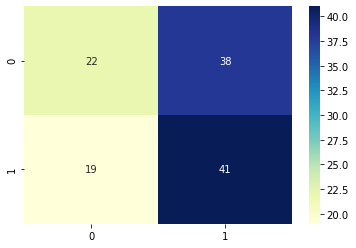

In [15]:
y_pred0 = r0.run_visible(testing_data)
y_pred1 = r1.run_visible(y_pred0)
y_pred2 = r2.run_visible(y_pred1)
y_pred3 = r3.run_visible(y_pred2)
y_pred4 = r4.run_visible(y_pred3)

crt = 0.0
y_test = []

for i in range(60):
  y_test.append(0)
for i in range(60):
  y_test.append(1)

print('Confusion Matrix')
cnf = sns.heatmap(confusion_matrix(y_test, y_pred4), cmap="YlGnBu", annot=True)
print(cnf)
print('Classification Report')
target_names = ['retouched', 'not_retouched']
print(classification_report(y_test, y_pred4, target_names=target_names))